In [47]:
import os 
import pandas as pd
import numpy as np
import subprocess
import glob
import pybedtools as pbt 
from IPython.display import HTML
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.min_rows', 100) 
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'

pbt.set_bedtools_path('/mnt/BioHome/jreyna/software/anaconda3/envs/hic_tls/bin/')
pbt.set_tempdir('/mnt/hpcscratch/jreyna/')
os.chdir('/mnt/BioHome/jreyna/jreyna/projects/dchallenge/')

gsizes = 'results/refs/hg19/hg19.chrom.sizes'
res = 5000

# make the directory to save our data
outdir = 'results/main/coloc/sgl_intersect/'
os.makedirs(outdir, exist_ok=True)
bedpe_cols = ['chrA', 'startA', 'endA', 'chrB', 'startB', 'endB']

## Loading the gene data

In [9]:
print('# Load the gene data')

genes_fn = 'results/refs/gencode/v30/gencode.v30.annotation.bed'

# load the gencode coords
cols = ['chrom', 'start', 'end', 'strand', 'type', 'gene_id', 'gname']
gencode = pd.read_table(genes_fn, header=None, names=cols)

# extract just the genes
genes_df = gencode.loc[gencode['type'].isin(['gene'])]
genes_df = genes_df.loc[~genes_df.duplicated(subset='gene_id'), :]
genes_df.loc[:, 'chrom'] = genes_df['chrom'].astype(str)
genes_df = genes_df.iloc[:, [0,1,2,6,5,3]]

# create a copy of the original gene bed before coordinate shrinking
orig_genes_df = genes_df.copy()

# convert the start/end position into start/end for the TSS
# if the gene is + then the start is uses as the tss otherwise
# the end is used as the tss
genes_df.loc[(genes_df.strand == '+'), 'end'] = genes_df.loc[(genes_df.strand == '+'), 'start']
genes_df.loc[(genes_df.strand == '+'), 'start'] = genes_df.loc[(genes_df.strand == '+'), 'start'] - 1
genes_df.loc[(genes_df.strand == '-'), 'end'] = genes_df.loc[(genes_df.strand == '-'), 'end']
genes_df.loc[(genes_df.strand == '-'), 'start'] = genes_df.loc[(genes_df.strand == '-'), 'end'] - 1
genes_df.loc[:, 'chrom'] = genes_df.loc[:, 'chrom'].str.replace('chr', '')
genes_df.loc[:, 'bin_start'] = (np.floor(genes_df.loc[:, 'start'] / res) * res).astype(int)
genes_df.loc[:, 'bin_end'] = genes_df.loc[:, 'bin_start'] + res

# make a genes pbt for intersection
print("# make a genes pbt for intersection")
print(genes_df.head())
genes_pbt = pbt.BedTool.from_dataframe(genes_df).sort()

print('There are {} genes in this GTF-derived file.'.format(genes_df.shape[0]))

# Load the gene data
# make a genes pbt for intersection
   chrom  start    end        gname          gene_id strand  bin_start  \
0      1  11868  11869      DDX11L1  ENSG00000223972      +      10000   
12     1  29569  29570       WASH7P  ENSG00000227232      -      25000   
25     1  17435  17436    MIR6859-1  ENSG00000278267      -      15000   
28     1  29553  29554  MIR1302-2HG  ENSG00000243485      +      25000   
36     1  30365  30366    MIR1302-2  ENSG00000284332      +      30000   

    bin_end  
0     15000  
12    30000  
25    20000  
28    30000  
36    35000  
There are 58825 genes in this GTF-derived file.


In [10]:
# get reference files 
genome_sizes="results/refs/hg19/hg19.chrom.sizes"

# loading the sample sheet
samplesheet = pd.read_table('config/sgl_samplesheets/sgl.samplesheet.tsv')
samplesheet = samplesheet.loc[~samplesheet['eqtl_source'].isna()]

In [11]:
# create the tamplate names for coloc files
coloc_template = 'results/main/GRCh37/coloc/{eqtl_db}/{gwas_source}/{eqtl_source}/{ge_source}/ldpairs/coloc_ld_snps.swapped_ld_cols.tsv'

all_colocs_data = []
sgl_data = []
curr_id = 0
# get the colocs and intersect
for i, sr in samplesheet.iterrows():
    
    print(i)
    
    # these samples have not been processed correctly so I'm skipping them for now
    if i in [120, 124, 125, 126, 127, 128, 129, 130]:
        continue
    
    sample_info = sr.to_dict()
    
    if sr.eqtl_source == 'ImmuNexUT':
        sample_info['eqtl_db'] = 'ImmuNexUT'
    else:
        sample_info['eqtl_db'] = 'eQTL_Catalogue'
    
    coloc_fn = coloc_template.format(**sample_info)

    # processs only if the coloc file exists
    if os.path.exists(coloc_fn) and sr['loop_source'] in hichip_pbts:

        # load and process colocs 
        colocs = pd.read_table(coloc_fn)
        colocs['coloc.id'] = range(curr_id, curr_id + len(colocs))
        colocs['gwas_source'] = sr['gwas_source']
        colocs['eqtl_source'] = sr['eqtl_source']
        colocs['ge_source'] = sr['ge_source']
        colocs['ge_source'] = sr['loop_source']

        # save the current colocs data
        all_colocs_data.append(colocs)
        
        #         # update the current coloc_id
        #         curr_id = curr_id + len(colocs)

        #         # start creating the coloc bedpe 
        #         colocs_bedpe = colocs[['chr', 'pos', 'pos', 'ld_rsID', 'geneName']]
        #         colocs_bedpe.columns = ['chr', 'start', 'end', 'rsid', 'genename']
        #         colocs_bedpe.loc[:, 'start'] = colocs_bedpe['start'] - 1

        #         # add gene coordinates 
        #         colocs_bedpe = colocs_bedpe.merge(genes_df, left_on='genename', right_on='gene_id', suffixes=['_snp', '_gene'])  

        #         # re-organize columns
        #         colocs_bedpe = colocs_bedpe[['chr', 'start_snp', 'end_snp',
        #                                      'chrom', 'start_gene', 'end_gene',
        #                                      'rsid', 'genename', 'gname', 'gene_id',
        #                                      'strand', 'bin_start', 'bin_end']]

        #         # re-name columns
        #         colocs_bedpe.columns = ['chr_snp', 'start_snp', 'end_snp', 'chr_gene', 'start_gene', 'end_gene',
        #                                 'rsid', 'geneid', 'genename', 'geneid2', 'strand_gene', 'bin_start', 'bin_end']

        #         # add chr to column entris 
        #         colocs_bedpe['chr_gene'] = 'chr' + colocs_bedpe['chr_gene'].astype(str)

        #         # add a coloc id for merging
        #         colocs_bedpe['coloc.id'] = range(len(colocs_bedpe))

        #         sgl_data.append(inter)
            

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
46
47
48
49
50
51
52
53
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188


In [34]:
all_colocs = pd.concat(all_colocs_data)

In [35]:
all_colocs['geneName'] = all_colocs.geneName.str.replace('\.[0-9]+', '')

/mnt/hpcscratch/jreyna//ipykernel_120217/1422885990.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  all_colocs['geneName'] = all_colocs.geneName.str.replace('\.[0-9]+', '')


In [36]:
all_colocs = all_colocs.merge(genes_df, left_on='geneName', right_on='gene_id')

In [39]:
all_colocs[['rsID', 'gname', 'dist']].drop_duplicates()

,rsID,gname,dist
0,rs10814917,GLIS3,51962
17,rs4380994,GLIS3,65856
35,rs17207042,DOK6,469227
123,rs1788105,DOK6,464001
172,rs1788097,DOK6,475397
218,rs1788097,DOK6,475564
264,rs1615504,DOK6,458520
310,rs3018275,DOK6,457733
410,rs1790588,DOK6,466893
566,rs763361,DOK6,463351


array([[<AxesSubplot:title={'center':'dist'}>]], dtype=object)

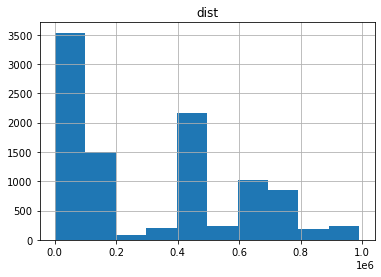

In [40]:
all_colocs.hist(column='dist')

In [43]:
low_eqtl_fdr = all_colocs.loc[all_colocs.FDR < 0.05]

In [44]:
low_eqtl_fdr[['rsID', 'gname', 'dist']].drop_duplicates()

,rsID,gname,dist
35,rs17207042,DOK6,469227
123,rs1788105,DOK6,464001
172,rs1788097,DOK6,475397
218,rs1788097,DOK6,475564
264,rs1615504,DOK6,458520
310,rs3018275,DOK6,457733
410,rs1790588,DOK6,466893
566,rs763361,DOK6,463351
713,rs1790932,DOK6,465109
812,rs36024512,DOK6,454234


array([[<AxesSubplot:title={'center':'dist'}>]], dtype=object)

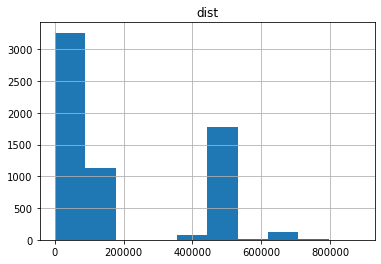

In [45]:
low_eqtl_fdr.hist(column='dist', )

<AxesSubplot:xlabel='dist', ylabel='Percent'>

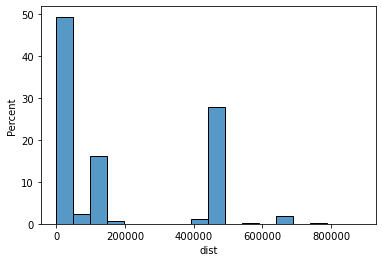

In [50]:
sns.histplot(x='dist', stat='percent', data=low_eqtl_fdr)

In [46]:
low_eqtl_fdr[['gname', 'dist']].drop_duplicates()

,gname,dist
35,DOK6,469227
123,DOK6,464001
172,DOK6,475397
218,DOK6,475564
264,DOK6,458520
310,DOK6,457733
410,DOK6,466893
566,DOK6,463351
713,DOK6,465109
812,DOK6,454234


In [52]:
low_eqtl_fdr_high_dist = low_eqtl_fdr.loc[low_eqtl_fdr.dist > 100000]

In [55]:
low_eqtl_fdr_high_dist[['gname', 'gene_id', 'dist']].drop_duplicates()

,gname,gene_id,dist
35,DOK6,ENSG00000206052,469227
123,DOK6,ENSG00000206052,464001
172,DOK6,ENSG00000206052,475397
218,DOK6,ENSG00000206052,475564
264,DOK6,ENSG00000206052,458520
310,DOK6,ENSG00000206052,457733
410,DOK6,ENSG00000206052,466893
566,DOK6,ENSG00000206052,463351
713,DOK6,ENSG00000206052,465109
812,DOK6,ENSG00000206052,454234


In [61]:
sgls = pd.concat(sgl_data)
sgls.drop([14, 15, 16], axis=1, inplace=True)
sgls.columns = ['chr_snp', 'start_snp', 'end_snp', 'chr_gene', 'start_gene', 'end_gene',
               'coloc.id', 'chrA', 'startA', 'endA', 'chrB', 'startB', 'endB', 'loop.id']

In [63]:
sgls = sgls.merge(all_colocs, on='coloc.id', suffixes=['', '.coloc'])

In [7]:
sgls

NameError: name 'sgls' is not defined

In [5]:
#sgls = sgls.merge(hichip, on='loop.id', suffixes=['', '.loop'])

In [6]:
# sgl_fn = os.path.join(outdir, 'coloc_ld_sgls.tsv')
# sgls.to_csv(sgl_fn, sep='\t', index=False)